# Combat Dataset vs Phantom Simulator

Loads `resources/datasets/combat.pkl.xz`, runs each sample through `phantom/micro/simulator.py`
(via `NumpyLanchesterSimulator`), and compares prediction quality against simple baselines.

In [1]:
from __future__ import annotations

import lzma
import pickle
import sys
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

ROOT = Path.cwd()
if not (ROOT / "phantom").exists():
    ROOT = ROOT.parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from phantom.micro.simulator import ModelCombatSetup, NumpyLanchesterSimulator, SimulationUnit

DATASET_PATH = ROOT / "resources/datasets/combat.pkl.xz"
MAX_SAMPLES: int | None = None  # set e.g. 2000 for a faster pass
SEED = 7

rng = np.random.default_rng(SEED)
print(f"Dataset: {DATASET_PATH}")

Dataset: C:\Users\volke\PycharmProjects\phantom-sc2\resources\datasets\combat.pkl.xz


In [2]:
with lzma.open(DATASET_PATH, "rb") as f:
    raw_data = pickle.load(f)

indices = np.arange(len(raw_data))
if MAX_SAMPLES is not None and MAX_SAMPLES < len(indices):
    indices = rng.choice(indices, size=MAX_SAMPLES, replace=False)

data = [raw_data[i] for i in indices]
print(f"Loaded {len(data):,} samples (from {len(raw_data):,} total)")
print("Example keys:", sorted(data[0].keys()))
print("Serialized unit keys:", sorted(data[0]["units"][0].keys()))

Loaded 10,000 samples (from 10,000 total)
Example keys: ['advantage_log', 'bitterness_log', 'units']
Serialized unit keys: ['air_dps', 'air_range', 'ground_dps', 'ground_range', 'health', 'is_enemy', 'is_flying', 'position', 'radius', 'real_speed', 'shield', 'tag']


In [3]:
@dataclass
class NotebookParameters:
    time_distribution_lambda: float = 1.0
    lancester_dimension: float = 1.5
    enemy_range_bonus: float = 1.0


def to_simulation_unit(u: dict) -> SimulationUnit:
    return SimulationUnit(
        tag=int(u["tag"]),
        is_enemy=bool(u["is_enemy"]),
        is_flying=bool(u["is_flying"]),
        health=float(u["health"]),
        shield=float(u["shield"]),
        ground_dps=float(u["ground_dps"]),
        air_dps=float(u["air_dps"]),
        ground_range=float(u["ground_range"]),
        air_range=float(u["air_range"]),
        radius=float(u["radius"]),
        real_speed=float(u["real_speed"]),
        position=(float(u["position"][0]), float(u["position"][1])),
    )


def to_model_setup(sample: dict) -> ModelCombatSetup:
    units1: list[SimulationUnit] = []
    units2: list[SimulationUnit] = []
    for unit_dict in sample["units"]:
        unit = to_simulation_unit(unit_dict)
        if unit.is_enemy:
            units2.append(unit)
        else:
            units1.append(unit)
    attacking = set[int]()
    attacking.update(u.tag for u in units1)
    attacking.update(u.tag for u in units2)
    return ModelCombatSetup(
        units1=units1,
        units2=units2,
        attacking=attacking,
    )


def sum_hp(units: list[SimulationUnit]) -> float:
    return float(sum(u.health + u.shield for u in units))


def sum_dps(units: list[SimulationUnit]) -> float:
    return float(sum(max(u.ground_dps, u.air_dps) for u in units))


sim = NumpyLanchesterSimulator(NotebookParameters(), num_steps=10)

In [4]:
rows = []
for sample in data:
    setup = to_model_setup(sample)
    if not setup.units1 or not setup.units2:
        continue

    pred = sim.simulate(setup).outcome_global
    hp1 = sum_hp(setup.units1)
    hp2 = sum_hp(setup.units2)
    dps1 = sum_dps(setup.units1)
    dps2 = sum_dps(setup.units2)

    rows.append({
        "true_raw": float(sample["advantage_log"]),
        "pred_sim": float(pred),
        "hp_ratio": (hp1 - hp2) / max(1e-9, hp1 + hp2),
        "dps_ratio": (dps1 - dps2) / max(1e-9, dps1 + dps2),
        "n1": len(setup.units1),
        "n2": len(setup.units2),
        "hp1": hp1,
        "hp2": hp2,
    })

print(f"Evaluated {len(rows):,} valid samples")
rows[:2]

Evaluated 10,000 valid samples


[{'true_raw': -0.1689413310118519,
  'pred_sim': -0.08280124675886272,
  'hp_ratio': 0.01281833063612532,
  'dps_ratio': -0.004040203473129513,
  'n1': 64,
  'n2': 64,
  'hp1': 6992.0,
  'hp2': 6815.01708984375},
 {'true_raw': -0.18718046243961606,
  'pred_sim': -0.09029430150571986,
  'hp_ratio': -0.0134891965301215,
  'dps_ratio': -0.0035523155977983363,
  'n1': 86,
  'n2': 86,
  'hp1': 9252.0,
  'hp2': 9505.01708984375}]

In [5]:
true_raw = np.array([r["true_raw"] for r in rows], dtype=float)
pred_sim = np.array([r["pred_sim"] for r in rows], dtype=float)
hp_ratio = np.array([r["hp_ratio"] for r in rows], dtype=float)
dps_ratio = np.array([r["dps_ratio"] for r in rows], dtype=float)

def sign_no_zero(x: np.ndarray) -> np.ndarray:
    y = np.sign(x)
    y[y == 0] = 1
    return y

y_sign = sign_no_zero(true_raw)

def metrics_for(name: str, pred: np.ndarray) -> dict:
    return {
        "model": name,
        "sign_accuracy": float((sign_no_zero(pred) == y_sign).mean()),
        "corr_to_true_raw": float(np.corrcoef(pred, true_raw)[0, 1]),
        "mae_to_true_raw": float(np.mean(np.abs(pred - true_raw))),
    }

metrics = [
    metrics_for("simulator", pred_sim),
    metrics_for("hp_ratio", hp_ratio),
    metrics_for("dps_ratio", dps_ratio),
]
metrics

[{'model': 'simulator',
  'sign_accuracy': 0.8715,
  'corr_to_true_raw': 0.27563557347168344,
  'mae_to_true_raw': 0.19922302319777643},
 {'model': 'hp_ratio',
  'sign_accuracy': 0.7935,
  'corr_to_true_raw': 0.8205064740882431,
  'mae_to_true_raw': 0.1938134486045145},
 {'model': 'dps_ratio',
  'sign_accuracy': 0.7735,
  'corr_to_true_raw': 0.42116231031348533,
  'mae_to_true_raw': 0.20316109322639764}]

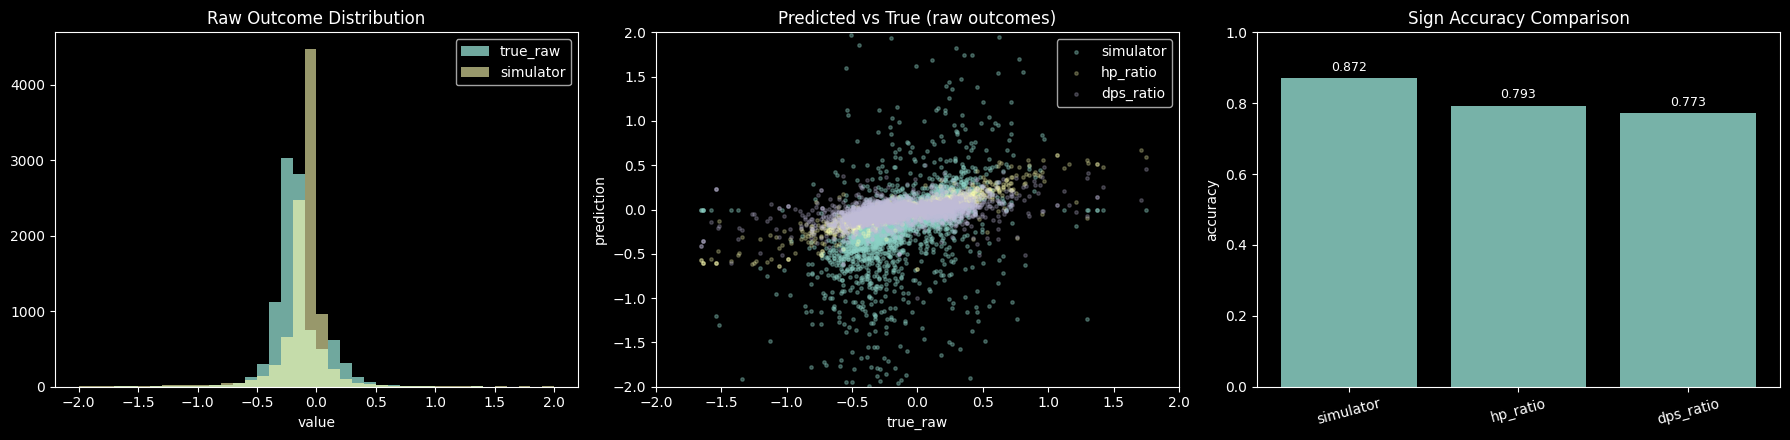

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

pred_range = (-2, 2)
axes[0].hist(true_raw, bins=40, alpha=0.8, label="true_raw", range=pred_range)
axes[0].hist(pred_sim, bins=40, alpha=0.6, label="simulator", range=pred_range)
axes[0].set_title("Raw Outcome Distribution")
axes[0].set_xlabel("value")
axes[0].legend()

axes[1].scatter(true_raw, pred_sim, s=6, alpha=0.35, label="simulator")
axes[1].scatter(true_raw, hp_ratio, s=6, alpha=0.25, label="hp_ratio")
axes[1].scatter(true_raw, dps_ratio, s=6, alpha=0.25, label="dps_ratio")
axes[1].set_xlim(*pred_range)
axes[1].set_ylim(*pred_range)
axes[1].set_title("Predicted vs True (raw outcomes)")
axes[1].set_xlabel("true_raw")
axes[1].set_ylabel("prediction")
axes[1].legend(loc="best")

models = [m["model"] for m in metrics]
acc = [m["sign_accuracy"] for m in metrics]
x = np.arange(len(models))
axes[2].bar(x, acc, alpha=0.85)
axes[2].set_xticks(x, models, rotation=15)
axes[2].set_ylim(0.0, 1.0)
axes[2].set_title("Sign Accuracy Comparison")
axes[2].set_ylabel("accuracy")
for i, v in enumerate(acc):
    axes[2].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

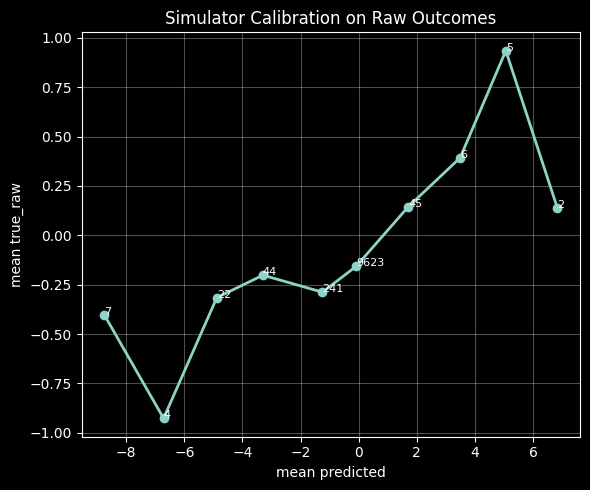

[{'bin_center': -8.46727641650907,
  'mean_pred': -8.75176172744684,
  'mean_true': -0.4030619246039381,
  'count': 7},
 {'bin_center': -6.7414871714832465,
  'mean_pred': -6.712636847540839,
  'mean_true': -0.9267023085446455,
  'count': 4},
 {'bin_center': -5.01569792645742,
  'mean_pred': -4.880811174664493,
  'mean_true': -0.31564795308800975,
  'count': 22},
 {'bin_center': -3.2899086814315948,
  'mean_pred': -3.2949132588369165,
  'mean_true': -0.2019257439304669,
  'count': 44},
 {'bin_center': -1.5641194364057696,
  'mean_pred': -1.2486810521634761,
  'mean_true': -0.28804163790790477,
  'count': 241},
 {'bin_center': 0.1616698086200561,
  'mean_pred': -0.08761567033044933,
  'mean_true': -0.15702137964485507,
  'count': 9623},
 {'bin_center': 1.8874590536458813,
  'mean_pred': 1.7007172027969009,
  'mean_true': 0.14361161627315888,
  'count': 45},
 {'bin_center': 3.6132482986717065,
  'mean_pred': 3.4899845810009817,
  'mean_true': 0.39245543851152376,
  'count': 6},
 {'bin_ce

In [7]:
bins = np.linspace(pred_sim.min(), pred_sim.max(), 11)
digitized = np.digitize(pred_sim, bins)
calibration = []
for b in range(1, len(bins)):
    mask = digitized == b
    count = int(mask.sum())
    if count == 0:
        continue
    calibration.append({
        "bin_center": float((bins[b - 1] + bins[b]) / 2),
        "mean_pred": float(pred_sim[mask].mean()),
        "mean_true": float(true_raw[mask].mean()),
        "count": count,
    })

cal_pred = np.array([c["mean_pred"] for c in calibration])
cal_true = np.array([c["mean_true"] for c in calibration])
cal_count = np.array([c["count"] for c in calibration])

plt.figure(figsize=(6, 5))
plt.plot(cal_pred, cal_true, marker="o", linewidth=2)
for x, y, c in zip(cal_pred, cal_true, cal_count):
    plt.text(x, y, str(int(c)), fontsize=8)
plt.title("Simulator Calibration on Raw Outcomes")
plt.xlabel("mean predicted")
plt.ylabel("mean true_raw")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

calibration

### Notes
- Comparisons are on raw outcome values (`result`) without normalization.
- `sign_accuracy` compares winner direction only (`result > 0` means `units1` wins).
- Absolute-scale metrics (`mae_to_true_raw`) are included as-is; known scale mismatch is a TODO.
- You can tune `NotebookParameters` to test alternative simulator parameter sets.